In [73]:
import socket, sys
socket.gethostname(), sys.executable


('login3', '/project/def-nahee/kbas/pone_offline/graphnet_env/bin/python')

##### - Definition of `residual_zenith` (degrees) :

$$
\mathrm{residual\_zenith\_degree}
=
\hat{\theta}_{\mathrm{zenith}}^{(\deg)}
-
\theta_{\mathrm{zenith,true}}^{(\deg)}
$$


##### - Interpreting the sign of `residual_zenith_degree`:

- `residual_zenith_degree = 0` → perfect prediction  
- `residual_zenith_degree > 0` → the model predicts a **larger zenith angle** than truth  
- `residual_zenith_degree < 0` → the model predicts a **smaller zenith angle** than truth  

**Note:** Zenith is not periodic like azimuth, so a simple difference usually makes sense.  
Typical range: $\theta_{\deg} \in [0,180^\circ]$  
$\Rightarrow$ residual roughly in $[-180^\circ, 180^\circ]$.



##### - Quantiles: p16, p50, p84: 

To summarize the distribution of `residual_zenith_degree`,

- **p50** = median (middle value) → can be interpreted as **bias**
- **p16** and **p84** = the 16th and 84th percentiles  
  (If residuals were Gaussian, these would roughly correspond to $\pm 1\sigma$ around the median.)



##### - Resolution proxy: `W`:

I define a resolution-like width using the central 68% interval:

$W = \frac{p84 - p16}{2}$

Interpretation:

- Small $W$ → tighter residual distribution → **better resolution**
- Large $W$ → wider residual distribution → **worse resolution**


# 0. Setup


In [74]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Consistent plotting defaults (no subsampling anywhere in this notebook)
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
})


In [75]:
zenith_test_predictions_path = Path("../zenith") / "test_predictions.csv"
zenith_metrics_path = Path("../zenith") / "metrics.csv"
zenith_resources_and_time_path =  Path("../zenith") /"resources_and_time.csv"

df_zenith_test_predictions = pd.read_csv(zenith_test_predictions_path)
df_zenith_metrics = pd.read_csv(zenith_metrics_path)
df_zenith_resources_and_time = pd.read_csv(zenith_resources_and_time_path)



# 1. Test Predictions (event-level)


## 1.1 Workflow
a) Confirm schema and NaNs/Infs  
b) Inspect the global residual distribution  
c) Inspect residual vs truth (trend + spread)  
d) Quantify resolution with **W** (equal-width and equal-population bins)  
e) Assess bias (median residual; and where relevant a ratio-based view)


## 1.2 Schema and integrity checks


In [76]:
print("shape:", df_zenith_test_predictions.shape)
print("columns:", list(df_zenith_test_predictions.columns))


shape: (41311, 8)
columns: ['true_zenith_radian', 'pred_zenith_radian', 'true_zenith_degree', 'pred_zenith_degree', 'kappa', 'event_id', 'residual_zenith_radian', 'residual_zenith_degree']


In [77]:
numeric_cols = df_zenith_test_predictions.select_dtypes(include=[np.number]).columns
minmax = df_zenith_test_predictions[numeric_cols].agg(["min", "max"]).T

print(minmax)


                               min            max
true_zenith_radian        0.005549       3.129967
pred_zenith_radian        0.052751       3.083370
true_zenith_degree        0.317949     179.333893
pred_zenith_degree        3.022416     176.664078
kappa                     1.100868     123.041382
event_id                 18.000000  402910.000000
residual_zenith_radian   -2.264318       1.783003
residual_zenith_degree -129.735840     102.158539


## 1.3 Column ranges (min / max)


In [78]:
print("Rows:", len(df_zenith_test_predictions))
print("\nNaN counts (all columns):")
print(df_zenith_test_predictions.isna().sum())


Rows: 41311

NaN counts (all columns):
true_zenith_radian        0
pred_zenith_radian        0
true_zenith_degree        0
pred_zenith_degree        0
kappa                     0
event_id                  0
residual_zenith_radian    0
residual_zenith_degree    0
dtype: int64


In [79]:
# Inf / -Inf counts in numeric columns (auto)
num_df = df_zenith_test_predictions.apply(pd.to_numeric, errors="coerce")

inf_pos = np.isposinf(num_df).sum()
inf_neg = np.isneginf(num_df).sum()
inf_any = np.isinf(num_df).sum()

out = pd.DataFrame({
    "+inf": inf_pos,
    "-inf": inf_neg,
    "any_inf": inf_any
}).sort_values("any_inf", ascending=False)

print("Inf counts (numeric columns):")
print(out)


Inf counts (numeric columns):
                        +inf  -inf  any_inf
true_zenith_radian         0     0        0
pred_zenith_radian         0     0        0
true_zenith_degree         0     0        0
pred_zenith_degree         0     0        0
kappa                      0     0        0
event_id                   0     0        0
residual_zenith_radian     0     0        0
residual_zenith_degree     0     0        0


## 1.4 Global summary (quantiles and W)


In [80]:
# ----  global W over the full test set ----
r = df_zenith_test_predictions["residual_zenith_degree"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")


p16=-3.7265, p50=-0.3114, p84=3.5497, W=3.6381


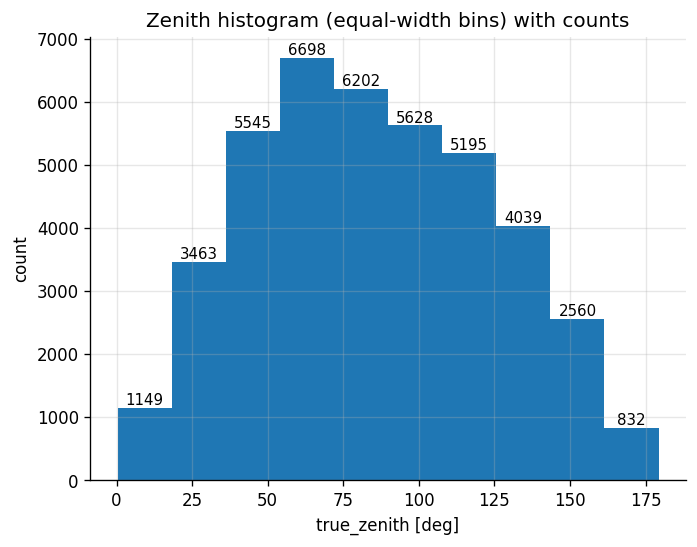

In [81]:
# ---- Zenith: histogram with counts annotated on top of bars ----
n_bins_zenith = 10
bins_zenith = np.linspace(
    df_zenith_test_predictions["true_zenith_degree"].min(),
    df_zenith_test_predictions["true_zenith_degree"].max(),
    n_bins_zenith + 1,
)
values = df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_zenith)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("true_zenith [deg]")
plt.ylabel("count")
plt.title("Zenith histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


## 1.5 Residual distribution


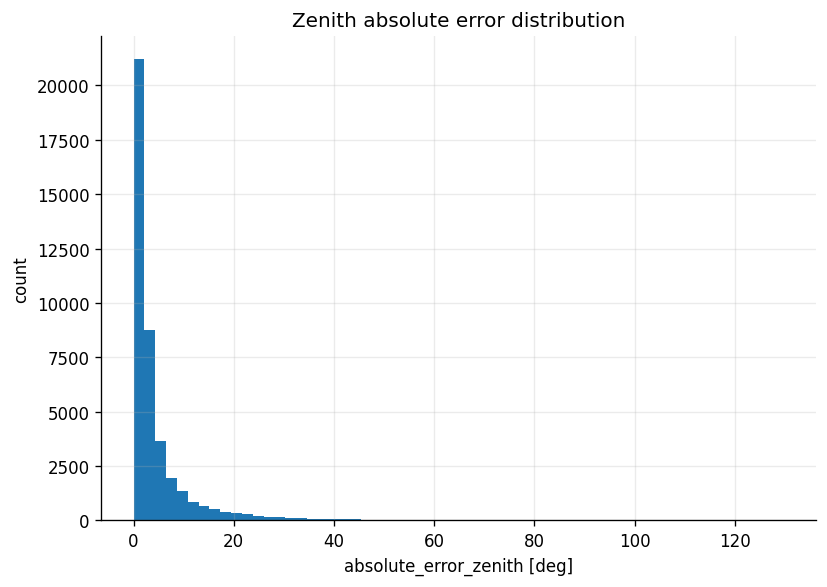

In [82]:
# ---- Absolute error distribution (full test set) ----
abs_err_deg = np.abs(r)

plt.figure(figsize=(7, 5))
plt.hist(abs_err_deg, bins=60)
plt.xlabel("absolute_error_zenith [deg]")
plt.ylabel("count")
plt.title("Zenith absolute error distribution")
plt.tight_layout()
plt.show()


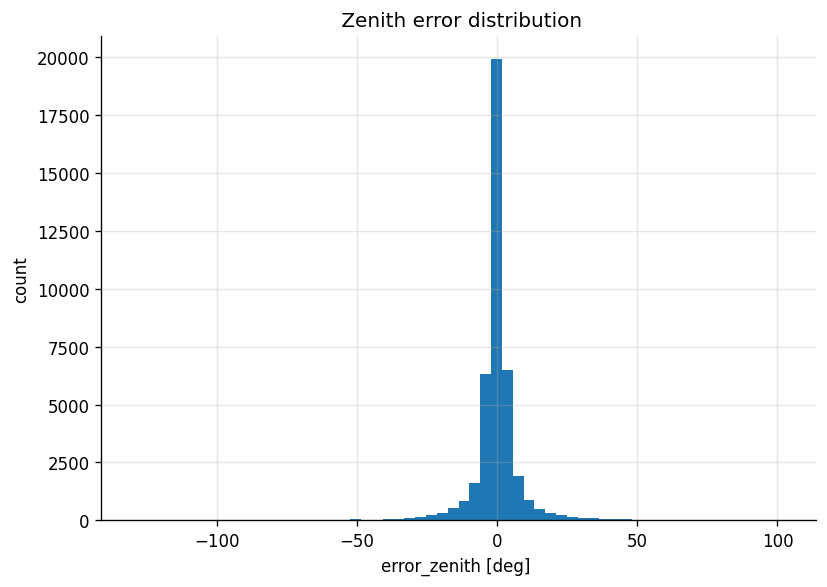

In [83]:
plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("error_zenith [deg] ")
plt.ylabel("count")
plt.title(" Zenith error distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.6 Residual vs truth (trend + spread)


This diagnostic below shows how the **zenith residual** behaves across the zenith range:

- Each blue point is one event:  
  $r = \widehat{\theta} - \theta_\mathrm{true}$  
  where $\theta$ is the zenith angle in **degrees**.
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across zenith.
- If it drifts above 0 → systematic **overestimation** of zenith.
- If it drifts below 0 → systematic **underestimation** of zenith.
- If the vertical spread increases for certain zenith ranges → **worsening resolution** in those regions (larger event-to-event scatter).

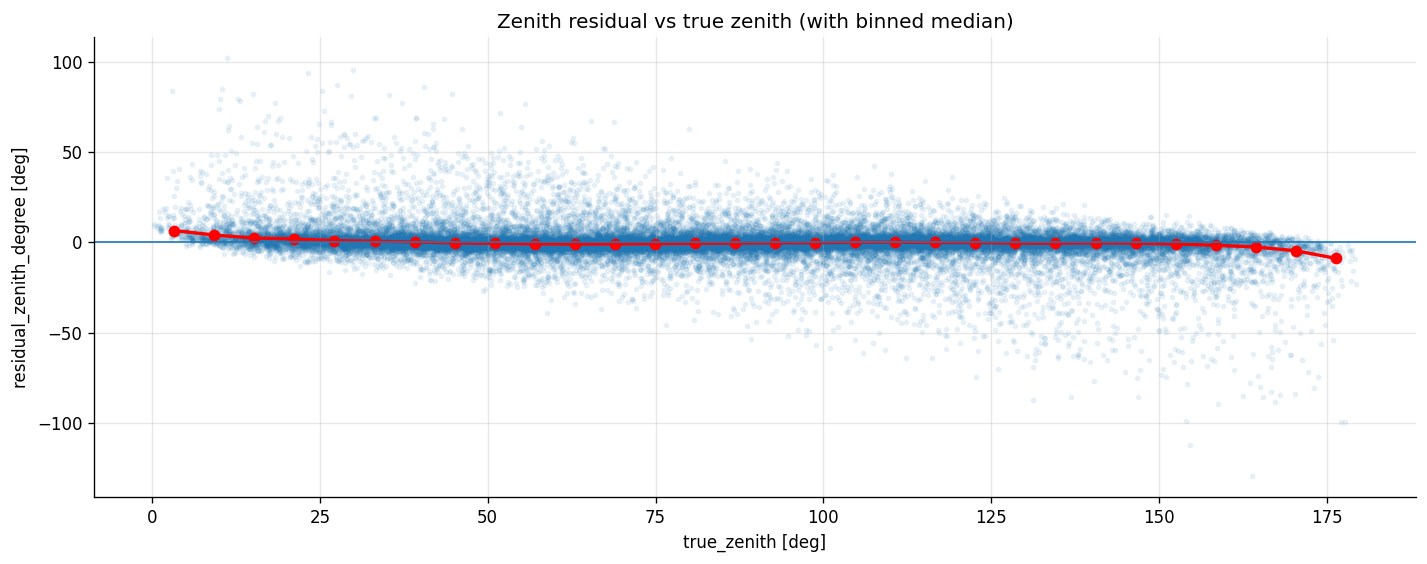

In [84]:
# ---- Zenith: residual vs true_zenith scatter + binned median (NO subsample) ----

x = df_zenith_test_predictions["true_zenith_degree"].to_numpy(dtype=float)


plt.figure(figsize=(12, 4.8))
plt.scatter(x, r, s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    m = (x >= left) & (x < right) if right != bins[-1] else (x >= left) & (x <= right)
    median_r.append(np.median(r[m]) if np.any(m) else np.nan)

median_r = np.array(median_r, dtype=float)

plt.plot(bin_centers, median_r, marker="o", linewidth=2, color="r")
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("true_zenith [deg]")
plt.ylabel("residual_zenith_degree [deg]")
plt.title("Zenith residual vs true zenith (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 1.7 Calibration (predicted vs true)


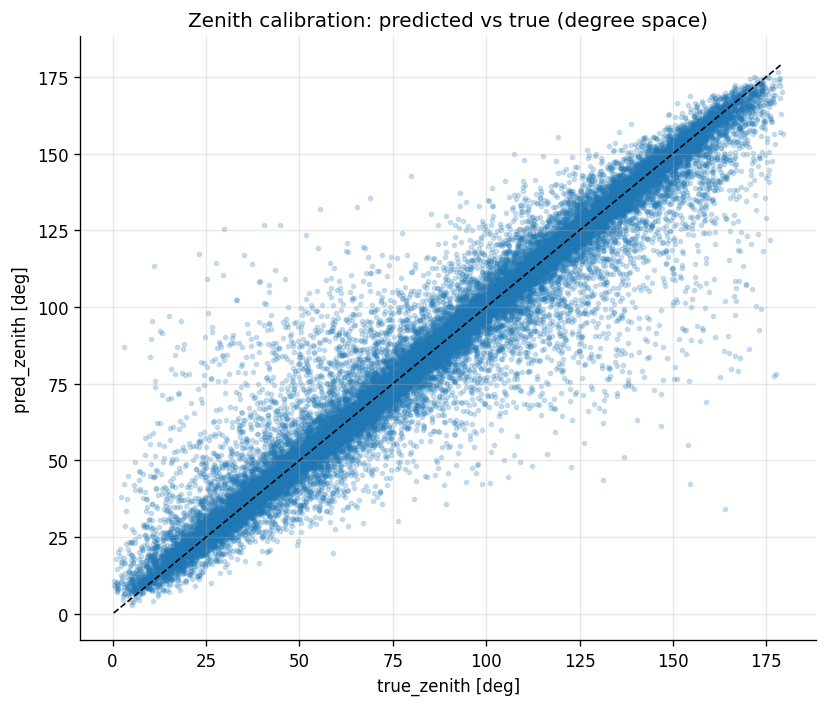

In [85]:
# ---- Zenith: calibration scatter (pred_zenith vs true_zenith) ----

plt.figure(figsize=(7, 6))

plt.scatter(
    df_zenith_test_predictions["true_zenith_degree"],
    df_zenith_test_predictions["pred_zenith_degree"],
    s=6, alpha=0.2
)

xmin = df_zenith_test_predictions["true_zenith_degree"].min()
xmax = df_zenith_test_predictions["true_zenith_degree"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x

plt.xlabel("true_zenith [deg]")
plt.ylabel("pred_zenith [deg]")
plt.title("Zenith calibration: predicted vs true (degree space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 1.8 Resolution vs truth (W)


In [86]:
# ---- Zenith: W table per zenith bin (using residual_zenith in radians) ----

df_zenith_w_rows = []


# Use histogram edges from your zenith hist cell:
# counts, edges, patches = plt.hist(...)
# If your variable name is edges_zenith, replace edges -> edges_zenith below.
for left, right in zip(edges[:-1], edges[1:]):
    # match matplotlib hist logic: [left, right) except last bin includes right
    if right == edges[-1]:
        mask = (df_zenith_test_predictions["true_zenith_degree"] >= left) & (df_zenith_test_predictions["true_zenith_degree"] <= right)
    else:
        mask = (df_zenith_test_predictions["true_zenith_degree"] >= left) & (df_zenith_test_predictions["true_zenith_degree"] < right)


    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_zenith_w_rows.append({
        "Zbin": f"({left:.3f}, {right:.3f}]",
        "Z_center_deg": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table = pd.DataFrame(df_zenith_w_rows)
df_zenith_W_table


,Zbin,Z_center_deg,count,p16,p50,p84,W
0,"(0.318, 18.220]",9.268746,41311,-3.726548,-0.311429,3.5497,3.638124
1,"(18.220, 36.121]",27.170341,41311,-3.726548,-0.311429,3.5497,3.638124
2,"(36.121, 54.023]",45.071935,41311,-3.726548,-0.311429,3.5497,3.638124
3,"(54.023, 71.924]",62.973529,41311,-3.726548,-0.311429,3.5497,3.638124
4,"(71.924, 89.826]",80.875124,41311,-3.726548,-0.311429,3.5497,3.638124
5,"(89.826, 107.728]",98.776718,41311,-3.726548,-0.311429,3.5497,3.638124
6,"(107.728, 125.629]",116.678313,41311,-3.726548,-0.311429,3.5497,3.638124
7,"(125.629, 143.531]",134.579907,41311,-3.726548,-0.311429,3.5497,3.638124
8,"(143.531, 161.432]",152.481501,41311,-3.726548,-0.311429,3.5497,3.638124
9,"(161.432, 179.334]",170.383096,41311,-3.726548,-0.311429,3.5497,3.638124


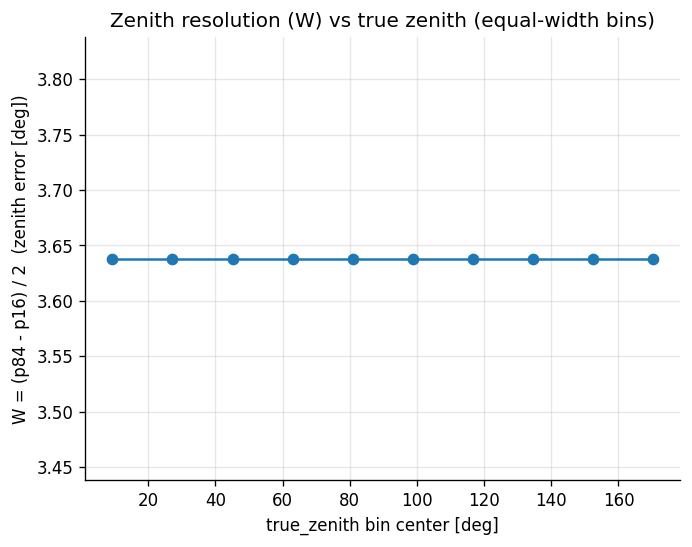

In [87]:
# ---- Zenith: plot W vs true zenith (equal-width bins) ----

plt.figure()
plt.plot(df_zenith_W_table["Z_center_deg"], df_zenith_W_table["W"], marker="o")
plt.xlabel("true_zenith bin center [deg]")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [deg])")
plt.title("Zenith resolution (W) vs true zenith (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()



In the **equal-width** zenith binning, the number of events per bin may not be **uniform** (see section 1.4).  
Depending on the underlying event distribution, some zenith regions may contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens in those zenith ranges.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [88]:
# ---- create equal-population bins (qcut) ----

n_qbins_zenith = 10

df_zenith_test_predictions["Zbin_q"] = pd.qcut(
    df_zenith_test_predictions["true_zenith_degree"],
    q=n_qbins_zenith,
    duplicates="drop",
)


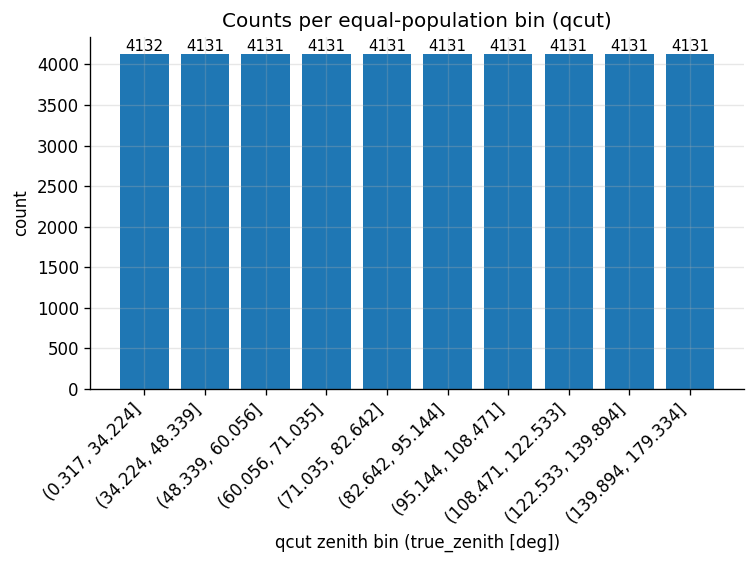

In [89]:
# ---- plot counts per qcut bin ----

bin_counts_q = df_zenith_test_predictions["Zbin_q"].value_counts().sort_index()

plt.figure()
plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(
    range(len(bin_counts_q)),
    [str(i) for i in bin_counts_q.index],
    rotation=45,
    ha="right",
)
plt.xlabel("qcut zenith bin (true_zenith [deg])")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


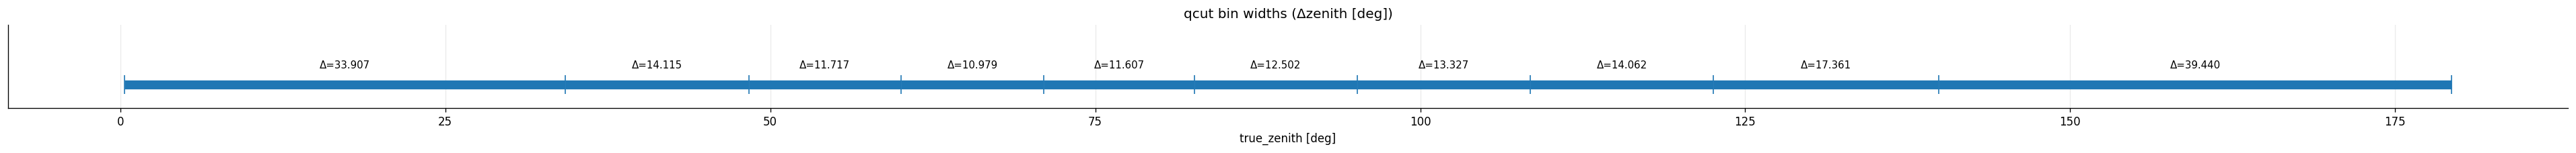

In [90]:
# ---- Visualize qcut bin widths only (in zenith radian space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("true_zenith [deg]")
plt.title("qcut bin widths (Δzenith [deg])")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [91]:
# ---- Zenith: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_zenith_q = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["residual_zenith_degree"]).to_numpy(dtype=float)  # residual in radians

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_zenith_q.append({
        "Zbin_q": str(iv),
        "Z_center_deg": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,  # radians
    })

df_zenith_W_table_q = pd.DataFrame(rows_zenith_q).sort_values("Z_center_deg")
df_zenith_W_table_q


,Zbin_q,Z_center_deg,count,p16,p50,p84,W
0,"(0.317, 34.224]",17.2705,4132,-1.813592,1.533958,8.487401,5.150496
1,"(34.224, 48.339]",41.2815,4131,-2.875648,0.005741,4.512763,3.694205
2,"(48.339, 60.056]",54.1975,4131,-3.233070,-0.748660,3.036051,3.134560
3,"(60.056, 71.035]",65.5455,4131,-3.330381,-0.923203,2.598442,2.964411
4,"(71.035, 82.642]",76.8385,4131,-3.437228,-0.675431,2.670252,3.053740
5,"(82.642, 95.144]",88.8930,4131,-3.493953,-0.334918,3.158613,3.326283
6,"(95.144, 108.471]",101.8075,4131,-3.520911,-0.097918,3.287938,3.404425
7,"(108.471, 122.533]",115.5020,4131,-3.862782,0.000301,3.279556,3.571169
8,"(122.533, 139.894]",131.2135,4131,-5.155331,-0.352124,2.961917,4.058624
9,"(139.894, 179.334]",159.6140,4131,-9.847650,-1.200092,2.399213,6.123431


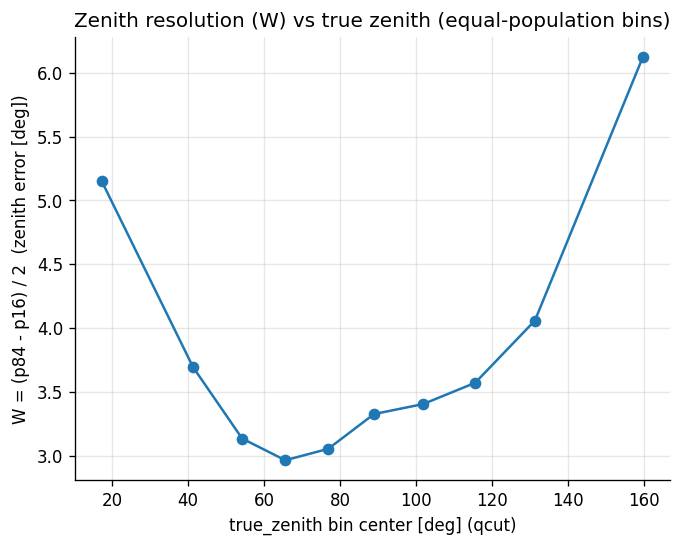

In [92]:
# ---- Zenith: plot W vs true zenith (qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["W"], marker="o")
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (zenith error [deg])")
plt.title("Zenith resolution (W) vs true zenith (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the **zenith residual** distribution  
$r = \widehat{\theta} - \theta_\mathrm{true}$ in each zenith bin (units: **angles**).

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the zenith angle, and does this depend on zenith?


## 1.9 Bias diagnostics: two approaches 


### 1.9.1: **Median residual vs zenith**  

If we define the zenith residual (in degrees) as  
$r = \widehat{\theta} - \theta_\mathrm{true}$,

then:

- $p50 \approx 0$ → unbiased in that zenith region  
- $p50 > 0$ → systematic overestimation of zenith  
- $p50 < 0$ → systematic underestimation of zenith


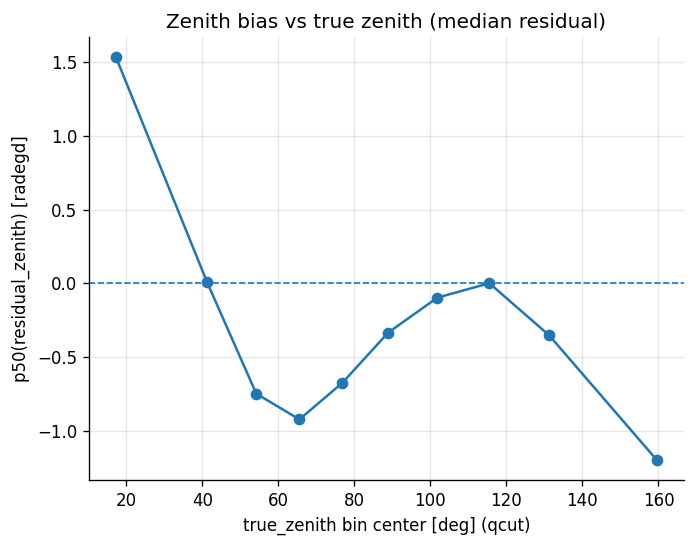

In [93]:
# ---- Zenith: bias vs true zenith (median residual, qcut bins) ----

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("p50(residual_zenith) [radegd]")
plt.title("Zenith bias vs true zenith (median residual)")
plt.grid(True, alpha=0.3)
plt.show()


### 1.9.2: Median absolute error vs zenith 



Because the signed residual can cancel out, it is also useful to track the typical *magnitude* of the error:

- $p50(|r|)$ in **degrees** 

Interpretation:
- smaller values → better angular accuracy
- larger values → worse angular accuracy in that zenith region




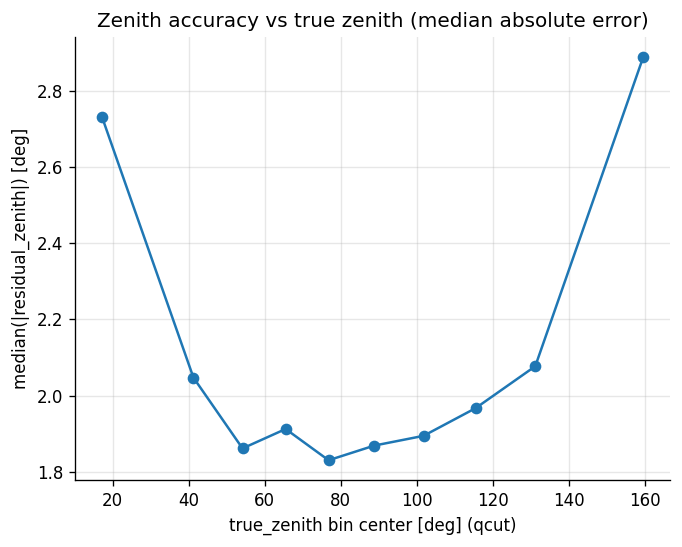

In [94]:
# ---- Zenith: median absolute error vs true zenith (qcut bins) ----

df_zenith_W_table_q["abs_p50_deg"] = np.nan  # keep style similar to your energy table edits

abs_rows = []
for iv, g in df_zenith_test_predictions.groupby("Zbin_q", observed=True):
    r = (g["pred_zenith_degree"] - g["true_zenith_degree"]).to_numpy(dtype=float)
    abs_rows.append((str(iv), np.median(np.abs(r))))

abs_map = dict(abs_rows)
df_zenith_W_table_q["abs_p50_deg"] = df_zenith_W_table_q["Zbin_q"].map(abs_map)

plt.figure()
plt.plot(df_zenith_W_table_q["Z_center_deg"], df_zenith_W_table_q["abs_p50_deg"], marker="o")
plt.xlabel("true_zenith bin center [deg] (qcut)")
plt.ylabel("median(|residual_zenith|) [deg]")
plt.title("Zenith accuracy vs true zenith (median absolute error)")
plt.grid(True, alpha=0.3)
plt.show()


# 2. Training Metrics (epoch-level)


## 2.1 Overview


In [95]:
print("shape:", df_zenith_metrics.shape)
print("columns:", list(df_zenith_metrics.columns))


shape: (25, 13)
columns: ['epoch', 'train_loss', 'val_loss', 'lr', 'best_model_is_updated', 'val_residual_p16_deg', 'val_residual_p50_deg', 'val_residual_p84_deg', 'val_W_deg', 'val_kappa_p16', 'val_kappa_p50', 'val_kappa_p84', 'val_kappa_W']


In [96]:
# Identify the epoch where the best model was last updated
if "best_model_is_updated" in df_zenith_metrics.columns:
    _mask = df_zenith_metrics["best_model_is_updated"].astype(bool)
    best_epoch = int(df_zenith_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
else:
    best_epoch = None

print(f"Best-model epoch (last update): {best_epoch}")


Best-model epoch (last update): 19


In [97]:
df_zenith_metrics.head(5)


,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_p16_deg,val_residual_p50_deg,val_residual_p84_deg,val_W_deg,val_kappa_p16,val_kappa_p50,val_kappa_p84,val_kappa_W
0,0,NaN,0.929326,0.000983,True,-8.759312,19.353519,48.020844,28.390078,1.897559,2.671419,3.833120,0.967781
1,1,1.085930,0.307592,0.000950,True,-15.077857,-2.255516,13.582484,14.330171,4.615460,6.661253,9.380403,2.382471
2,2,0.271237,-0.043635,0.000916,True,-10.006960,-0.116557,11.324690,10.665825,10.196954,15.405162,21.798265,5.800656
3,3,0.020096,-0.295191,0.000883,True,-2.714694,4.685554,12.412643,7.563668,13.182571,34.579227,55.284756,21.051092
4,4,-0.163107,-0.556590,0.000849,True,-8.358631,-1.537612,5.127803,6.743217,12.823052,53.694321,78.336052,32.756500


## 2.2 Training curves (loss & LR)


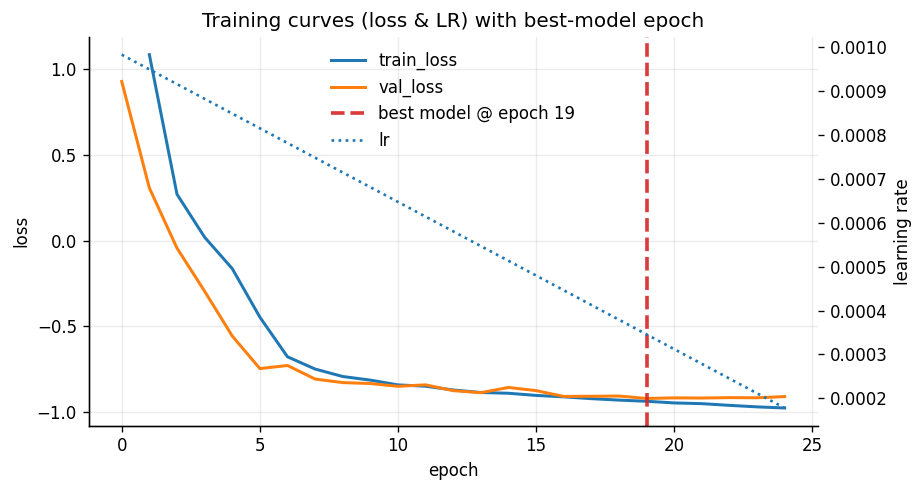

In [98]:
fig, ax = plt.subplots(figsize=(7.8, 4.2))

ax.plot(df_zenith_metrics["epoch"], df_zenith_metrics["train_loss"], label="train_loss", linewidth=1.8)
ax.plot(df_zenith_metrics["epoch"], df_zenith_metrics["val_loss"], label="val_loss", linewidth=1.8)

# Best-model epoch (last update)
if "best_model_is_updated" in df_zenith_metrics.columns:
    _mask = df_zenith_metrics["best_model_is_updated"].astype(bool)
    _best_epoch = int(df_zenith_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
else:
    _best_epoch = None

if _best_epoch is not None:
    ax.axvline(
        _best_epoch,
        color="tab:red",
        linestyle="--",
        linewidth=2.2,
        alpha=0.9,
        label=f"best model @ epoch {_best_epoch}",
    )

ax.set_xlabel("epoch")
ax.set_ylabel("loss")

ax2 = None
if "lr" in df_zenith_metrics.columns:
    ax2 = ax.twinx()
    ax2.plot(df_zenith_metrics["epoch"], df_zenith_metrics["lr"], label="lr", linestyle=":", linewidth=1.6)
    ax2.set_ylabel("learning rate")
    ax2.grid(False)

# Combined legend
handles, labels = ax.get_legend_handles_labels()
if ax2 is not None:
    h2, l2 = ax2.get_legend_handles_labels()
    handles += h2
    labels += l2
ax.legend(handles, labels, loc="best")

ax.set_title("Training curves (loss & LR) with best-model epoch")
fig.tight_layout()
plt.show()


## 2.3 Key validation metrics over epochs


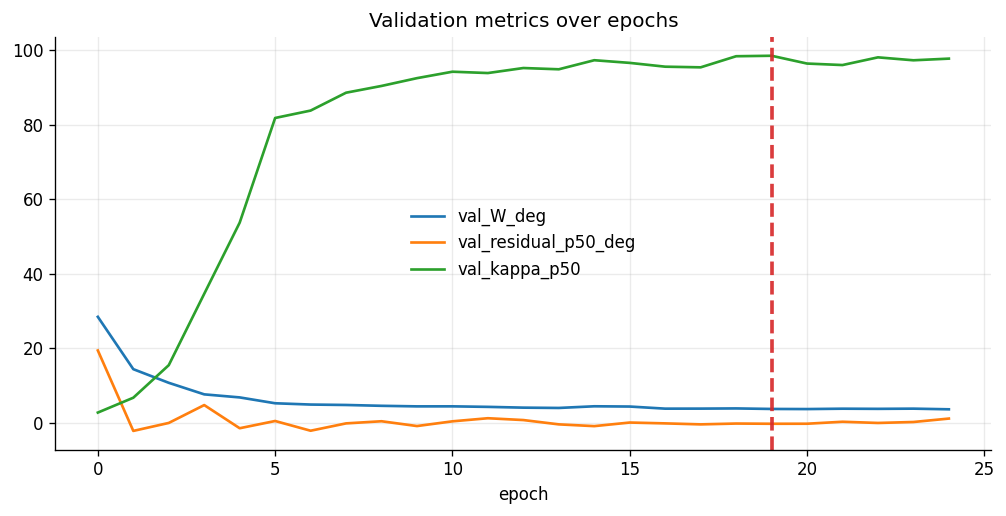

In [99]:
# Key validation metrics over epochs (from metrics.csv)
cols_to_plot = ["val_W_deg", "val_residual_p50_deg", "val_kappa_p50"]
cols_to_plot = [c for c in cols_to_plot if c in df_zenith_metrics.columns]

plt.figure(figsize=(8.5, 4.4))
for col in cols_to_plot:
    plt.plot(df_zenith_metrics["epoch"], df_zenith_metrics[col], label=col, linewidth=1.6)

if "best_model_is_updated" in df_zenith_metrics.columns:
    _mask = df_zenith_metrics["best_model_is_updated"].astype(bool)
    _best_epoch = int(df_zenith_metrics.loc[_mask, "epoch"].max()) if _mask.any() else None
    if _best_epoch is not None:
        plt.axvline(_best_epoch, color="tab:red", linestyle="--", linewidth=2.2, alpha=0.9)

plt.xlabel("epoch")
plt.title("Validation metrics over epochs")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


## 2.4 Snapshot (best vs last epoch)


In [100]:
# Best-epoch vs last-epoch snapshot (epoch-level metrics)
_last = df_zenith_metrics.tail(1).copy()
_last.insert(0, "which", "last_epoch")

if best_epoch is not None:
    _best = df_zenith_metrics.loc[df_zenith_metrics["epoch"] == best_epoch].tail(1).copy()
    _best.insert(0, "which", "best_epoch")
    snapshot = pd.concat([_best, _last], ignore_index=True)
else:
    snapshot = _last

snapshot


,which,epoch,train_loss,val_loss,lr,best_model_is_updated,val_residual_p16_deg,val_residual_p50_deg,val_residual_p84_deg,val_W_deg,val_kappa_p16,val_kappa_p50,val_kappa_p84,val_kappa_W
0,best_epoch,19,-0.937992,-0.921614,0.000346,True,-3.722862,-0.337920,3.562516,3.642689,34.495777,98.531952,102.292870,33.898544
1,last_epoch,24,-0.977235,-0.910554,0.000178,False,-2.728709,1.059875,4.368803,3.548756,42.607635,97.761032,101.301414,29.346889


# 3. Resource and Time Information (epoch-level)


## 3.1 What this file captures



`resources_and_time.csv` is written **once per epoch** (at the end of validation, via the callback).  
Each row is a **snapshot at an epoch boundary**, not a continuous measurement.

**Implications**
- `epoch_duration_min` is a good proxy for *epoch wall time* (train + val).
- `gpu_util_pct` can be **0% even if the GPU was busy earlier** in the epoch (because it is sampled at the end).
- `sys_mem_used_gb` and `cpu_load_pct` reflect **node-level** state and can be influenced by other processes on the same node.


## 3.2 Quick view and sanity checks

In [101]:
df_zenith_test_predictions.head(5)


,true_zenith_radian,pred_zenith_radian,true_zenith_degree,pred_zenith_degree,kappa,event_id,residual_zenith_radian,residual_zenith_degree,Zbin_q
0,0.390769,0.897717,22.389387,51.435383,12.699632,242,0.506948,29.045994,"(0.317, 34.224]"
1,1.441897,1.430777,82.614624,81.977478,102.253052,778,-0.011120,-0.637147,"(71.035, 82.642]"
2,1.758793,1.693512,100.771446,97.031097,95.955757,1171,-0.065281,-3.740348,"(95.144, 108.471]"
3,2.018402,2.060586,115.645912,118.062881,100.385437,1634,0.042184,2.416972,"(108.471, 122.533]"
4,0.521355,0.302265,29.871426,17.318506,80.609497,3741,-0.219090,-12.552919,"(0.317, 34.224]"


In [102]:
print("Shape:", df_zenith_resources_and_time.shape)
print("\nDtypes:")
print(df_zenith_resources_and_time.dtypes)

print("\nMissing values per column:")
print(df_zenith_resources_and_time.isna().sum())

elapsed = pd.to_numeric(df_zenith_resources_and_time["elapsed_min"], errors="coerce")
print("\nElapsed monotonic increasing:", elapsed.is_monotonic_increasing)

Shape: (25, 10)

Dtypes:
epoch                   int64
elapsed_min           float64
epoch_duration_min    float64
rss_gb                float64
sys_mem_used_gb       float64
cpu_load_pct          float64
gpu_util_pct          float64
gpu_mem_used_gb       float64
gpu_mem_total_gb      float64
gpu_mem_util_pct      float64
dtype: object

Missing values per column:
epoch                 0
elapsed_min           0
epoch_duration_min    0
rss_gb                0
sys_mem_used_gb       0
cpu_load_pct          0
gpu_util_pct          0
gpu_mem_used_gb       0
gpu_mem_total_gb      0
gpu_mem_util_pct      0
dtype: int64

Elapsed monotonic increasing: True


## 3.3 Timeline: elapsed time and epoch duration



Two independent ways to estimate epoch duration:
- `epoch_duration_min` (logged)
- `diff(elapsed_min)` (derived)


In [103]:
def _num(col: str):
    """Read a numeric column without modifying the original dataframe."""
    return pd.to_numeric(df_zenith_resources_and_time[col], errors="coerce")

epoch = _num("epoch")
elapsed = _num("elapsed_min")
epoch_dur_logged = _num("epoch_duration_min")
epoch_dur_from_elapsed = elapsed.diff()

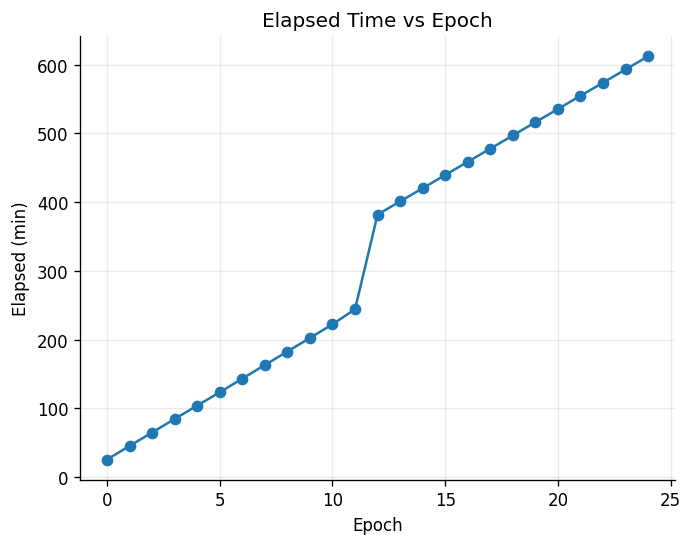

In [104]:
fig, ax = plt.subplots()
ax.plot(epoch, elapsed, marker="o")
ax.set_title("Elapsed Time vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Elapsed (min)")
plt.show()

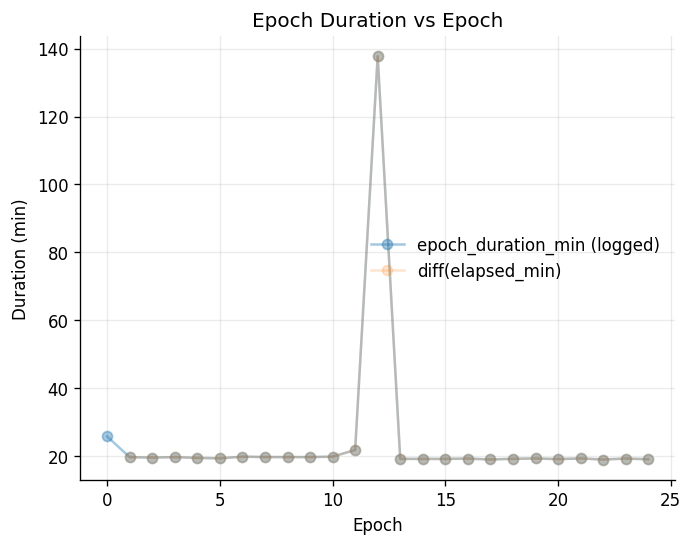

In [105]:
fig, ax = plt.subplots()
ax.plot(epoch, epoch_dur_logged, marker="o", label="epoch_duration_min (logged)", alpha=0.4)
ax.plot(epoch, epoch_dur_from_elapsed, marker="o", label="diff(elapsed_min)", alpha=0.2)
ax.set_title("Epoch Duration vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Duration (min)")
ax.legend()
plt.show()

In [106]:
dur = epoch_dur_logged.dropna()
total_time_min = float(elapsed.dropna().iloc[-1]) if elapsed.notna().any() else np.nan

print(f"Total elapsed (min): {total_time_min:.3f}")
print(
    "Epoch duration (min) | "
    f"mean={dur.mean():.3f}, std={dur.std(ddof=1):.3f}, "
    f"min={dur.min():.3f}, max={dur.max():.3f}"
)

slow_idx = epoch_dur_logged.nlargest(5).index
df_zenith_resources_and_time.loc[slow_idx, [
    "epoch", "epoch_duration_min", "cpu_load_pct", "gpu_util_pct",
    "gpu_mem_used_gb", "gpu_mem_util_pct", "rss_gb"
]]

Total elapsed (min): 612.271
Epoch duration (min) | mean=24.491, std=23.633, min=19.011, max=137.737


,epoch,epoch_duration_min,cpu_load_pct,gpu_util_pct,gpu_mem_used_gb,gpu_mem_util_pct,rss_gb
12,12,137.737,21.40,0.0,43.659,54.8,2.104
0,0,25.795,57.30,0.0,36.372,45.7,2.101
11,11,21.818,42.99,0.0,43.659,54.8,2.107
10,10,19.857,56.89,0.0,43.659,54.8,2.107
6,6,19.846,59.62,0.0,43.659,54.8,2.098


## 3.4 Resource curves (epoch-boundary snapshots)



The following plots help answer:
- **Is the run GPU-bound or input/CPU-bound?**
- **Is GPU memory saturated (batch size too large)?**
- **Is RAM growing (potential leak / caching effect)?**


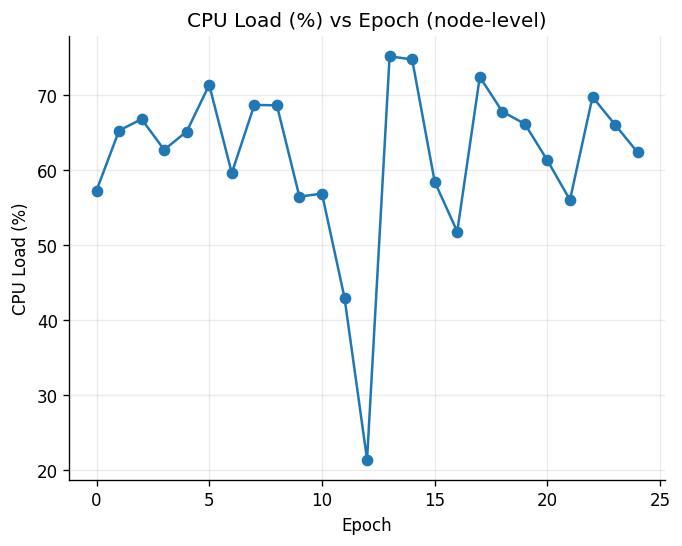

In [107]:
cpu = _num("cpu_load_pct")
fig, ax = plt.subplots()
ax.plot(epoch, cpu, marker="o")
ax.set_title("CPU Load (%) vs Epoch (node-level)")
ax.set_xlabel("Epoch")
ax.set_ylabel("CPU Load (%)")
plt.show()

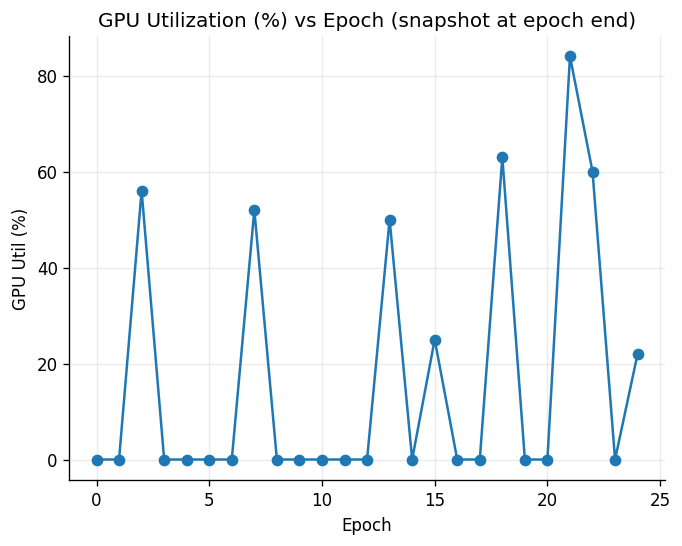

In [108]:
gpu_util = _num("gpu_util_pct")
fig, ax = plt.subplots()
ax.plot(epoch, gpu_util, marker="o")
ax.set_title("GPU Utilization (%) vs Epoch (snapshot at epoch end)")
ax.set_xlabel("Epoch")
ax.set_ylabel("GPU Util (%)")
plt.show()

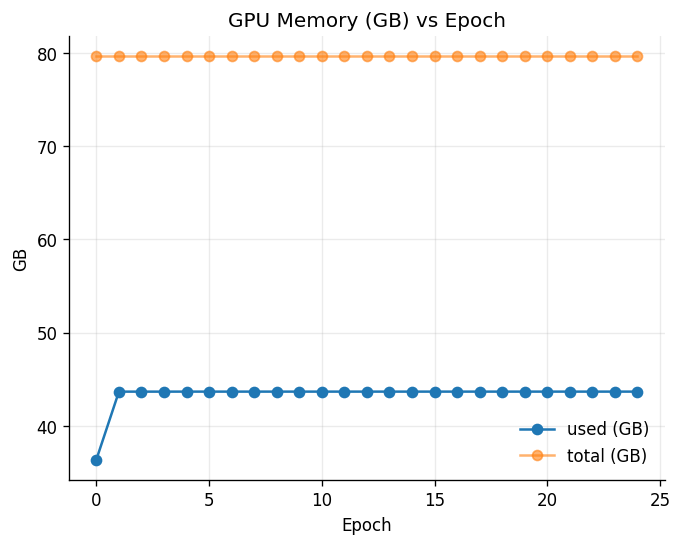

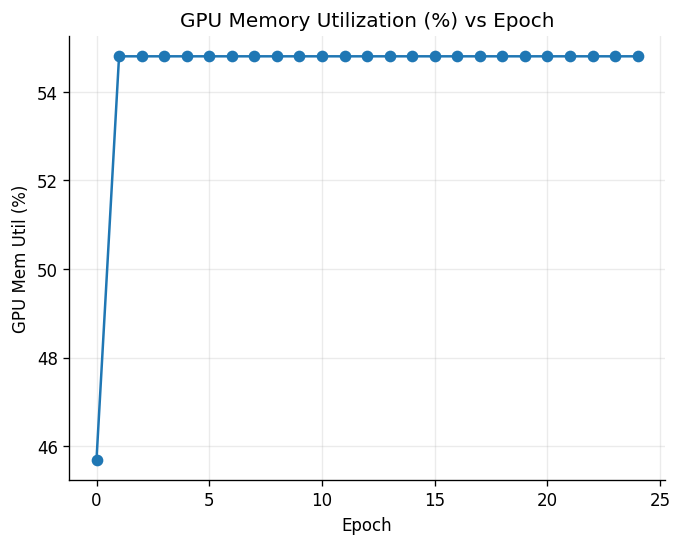

In [109]:
gpu_mem_used = _num("gpu_mem_used_gb")
gpu_mem_total = _num("gpu_mem_total_gb")
gpu_mem_util = _num("gpu_mem_util_pct")

fig, ax = plt.subplots()
ax.plot(epoch, gpu_mem_used, marker="o", label="used (GB)")
ax.plot(epoch, gpu_mem_total, marker="o", label="total (GB)", alpha=0.6)
ax.set_title("GPU Memory (GB) vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("GB")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(epoch, gpu_mem_util, marker="o")
ax.set_title("GPU Memory Utilization (%) vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("GPU Mem Util (%)")
plt.show()

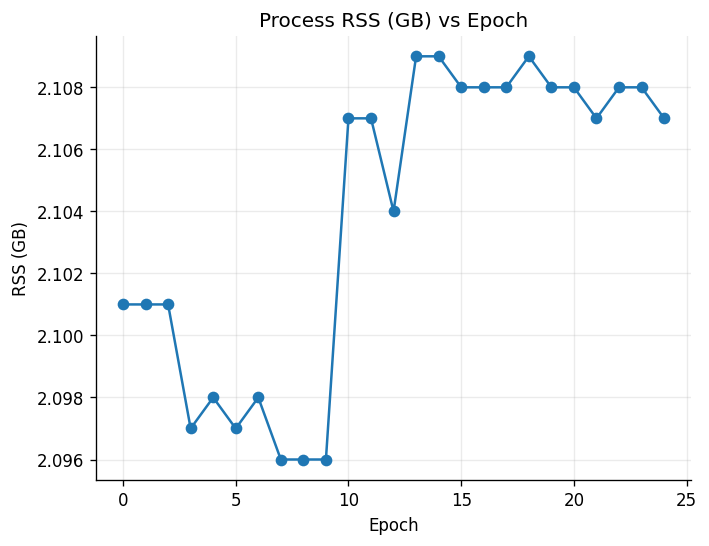

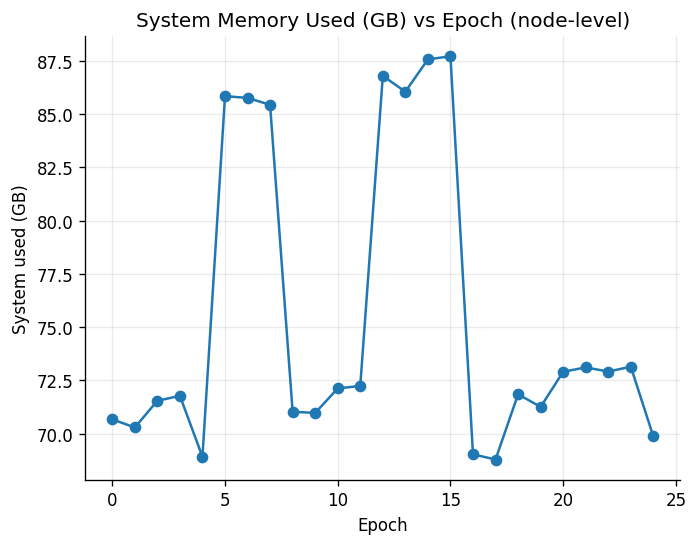

In [110]:
rss = _num("rss_gb")
sys_mem = _num("sys_mem_used_gb")

fig, ax = plt.subplots()
ax.plot(epoch, rss, marker="o")
ax.set_title("Process RSS (GB) vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("RSS (GB)")
plt.show()

fig, ax = plt.subplots()
ax.plot(epoch, sys_mem, marker="o")
ax.set_title("System Memory Used (GB) vs Epoch (node-level)")
ax.set_xlabel("Epoch")
ax.set_ylabel("System used (GB)")
plt.show()

## 3.5 Bottleneck heuristics



These are **heuristics**, not proofs—because the metrics are snapshots.  
Still, they help you decide what to tweak (batch size, num_workers, prefetch, etc.).


In [111]:
# Simple flags (tunable thresholds)
gpu_idle_mask = _num("gpu_util_pct").fillna(0) < 1.0
cpu_high_mask = _num("cpu_load_pct").fillna(0) > 90.0
slow_mask = epoch_dur_logged >= epoch_dur_logged.quantile(0.90)

mask = gpu_idle_mask | cpu_high_mask | slow_mask

cols = [
    "epoch", "epoch_duration_min",
    "cpu_load_pct", "gpu_util_pct",
    "gpu_mem_used_gb", "gpu_mem_util_pct",
    "rss_gb", "sys_mem_used_gb",
]
df_zenith_resources_and_time.loc[mask, cols].sort_values("epoch")

,epoch,epoch_duration_min,cpu_load_pct,gpu_util_pct,gpu_mem_used_gb,gpu_mem_util_pct,rss_gb,sys_mem_used_gb
0,0,25.795,57.30,0.0,36.372,45.7,2.101,70.676
1,1,19.696,65.30,0.0,43.657,54.8,2.101,70.293
3,3,19.707,62.74,0.0,43.657,54.8,2.097,71.778
4,4,19.476,65.17,0.0,43.659,54.8,2.098,68.919
5,5,19.350,71.39,0.0,43.659,54.8,2.097,85.844
6,6,19.846,59.62,0.0,43.659,54.8,2.098,85.764
8,8,19.716,68.67,0.0,43.659,54.8,2.096,71.032
9,9,19.716,56.48,0.0,43.659,54.8,2.096,70.977
10,10,19.857,56.89,0.0,43.659,54.8,2.107,72.125
11,11,21.818,42.99,0.0,43.659,54.8,2.107,72.245


In [112]:
# Correlations with epoch duration (numeric view; does NOT modify df)
metrics = [
    "cpu_load_pct", "gpu_util_pct",
    "gpu_mem_used_gb", "gpu_mem_util_pct",
    "rss_gb", "sys_mem_used_gb",
]
X = pd.concat([epoch_dur_logged.rename("epoch_duration_min")] + [_num(m).rename(m) for m in metrics], axis=1)
corr_to_dur = X.corr(numeric_only=True)["epoch_duration_min"].drop("epoch_duration_min").sort_values(ascending=False)

print("Correlation with epoch_duration_min (higher => tends to increase duration):")
corr_to_dur

Correlation with epoch_duration_min (higher => tends to increase duration):


sys_mem_used_gb     0.322805
rss_gb             -0.005117
gpu_mem_used_gb    -0.011461
gpu_mem_util_pct   -0.011496
gpu_util_pct       -0.140168
cpu_load_pct       -0.762348
Name: epoch_duration_min, dtype: float64

## 3.6 How to act on what you see (practical checklist)



**If GPU util is often low while CPU load is high**
- Data pipeline is likely the bottleneck → increase `num_workers`, enable `pin_memory`, `persistent_workers`,
  adjust `prefetch_factor`, consider faster storage / caching, avoid heavy Python transforms per batch.

**If GPU memory is close to full**
- Reduce `batch_size` (or model size), consider gradient accumulation instead of huge batches.

**If GPU memory is stable but epoch duration increases**
- Check for CPU/RAM pressure, background jobs on the same node, or increasing dataloader overhead.

**If process RSS grows steadily**
- Possible memory leak or accumulating caches → inspect dataloader caching, repeated object creation,
  and keep an eye on Python lists that grow across epochs.
